In [1]:
from EDA_preprocessing import preprocess_data
from sklearn.metrics import f1_score, classification_report

corrected = "./data/corrected"
kddcup_data = "./data/kddcup.data"

kddcup_data_10_percent_corrected = "./data/kddcup.data_10_percent_corrected"
kddcup_newtestdata_10_percent_unlabeled = "./data/kddcup.newtestdata_10_percent_unlabeled"

kddcup_testdata_unlabeled = "./data/kddcup.testdata.unlabeled"
kddcup_testdata_unlabeled_10_percent = "./data/kddcup.testdata.unlabeled_10_percent"

correspondence = "./data/training_attack_types.txt"

In [47]:
import pandas as pd

X_test_matrix = pd.read_csv('X_train.csv', header=0, index_col=0).as_matrix()
X_train_matrix = pd.read_csv("X_test.csv", header=0, index_col=0).as_matrix()
y_train_vector = pd.Series.from_csv("y_test.csv", header=None, index_col=0).as_matrix()
y_test_vector = pd.Series.from_csv('y_train.csv', header=None, index_col=0).as_matrix()

In [2]:
X_train_raw, y_train_raw, X_test_raw, y_test_raw, cat_features = preprocess_data(kddcup_data,
                                                   kddcup_testdata_unlabeled_10_percent,
                                                   "./data/headers",
                                                   "./data/training_attack_types.txt")

In [ ]:
X_train_matrix_raw = X_test.as_matrix()
X_test_matrix_raw = X_train.as_matrix()

In [4]:
y_train_vector_raw = y_test_raw.as_matrix()
y_test_vector_raw = y_train_raw.as_matrix()

# Model 1

In [69]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras import losses

batch_size = 64
epochs = 20
learning_rate = 0.001

model1 = Sequential()
model1.add(Dense(128, input_shape=(1, X_train_matrix.shape[1])))
model1.add(Dense(256))
model1.add(Dropout(0.1))
model1.add(Dense(5, activation='softmax'))

In [70]:
y_train_1 = (np.arange(5) == y_train_vector[:,None]).astype(np.int).reshape(-1, 1, 5)
y_test_1 = (np.arange(5) == y_test_vector[:,None]).astype(np.int).reshape(-1, 1, 5)

In [71]:
from custom_metrics import f1

adam = optimizers.Adam(lr=learning_rate, decay=1e-5)
model1.compile(loss=losses.categorical_crossentropy,
               optimizer=adam,
               metrics=['accuracy', f1])

In [72]:
history = model1.fit(np.reshape(X_train_matrix, (-1, 1, 37)), y_train_1, batch_size=batch_size, epochs=epochs)#,
                    #validation_data=(np.reshape(X_test_matrix, (-1, 1, 37)), y_test_1), )#, verbose=False)

Epoch 1/20
247247/247247 [==============================] - 13s - loss: 0.0352 - acc: 0.9918 - f1: nan    
Epoch 2/20
247247/247247 [==============================] - 13s - loss: 0.0286 - acc: 0.9929 - f1: 0.9929    
Epoch 3/20
247247/247247 [==============================] - 12s - loss: 0.0275 - acc: 0.9932 - f1: 0.9932    
Epoch 4/20
247247/247247 [==============================] - 12s - loss: 0.0268 - acc: 0.9932 - f1: 0.9932    
Epoch 5/20
247247/247247 [==============================] - 12s - loss: 0.0257 - acc: 0.9933 - f1: 0.9933    
Epoch 6/20
247247/247247 [==============================] - 12s - loss: 0.0246 - acc: 0.9934 - f1: 0.9934    
Epoch 7/20
247247/247247 [==============================] - 12s - loss: 0.0243 - acc: 0.9937 - f1: 0.9936    
Epoch 8/20
247247/247247 [==============================] - 12s - loss: 0.0238 - acc: 0.9937 - f1: 0.9937    
Epoch 9/20
247247/247247 [==============================] - 12s - loss: 0.0236 - acc: 0.9938 - f1: 0.9938    
Epoch 10/20
2

In [73]:
y_pred = model1.predict(X_test_matrix.reshape(-1, 1, 37), batch_size=batch_size)
target_names = ['normal','prop','dos','u2r','r2l']
y_pred = np.argmax(y_pred, axis=2)
print(scorer.classification_report(y_test_vector, y_pred, target_names=target_names, digits=4))

             precision    recall  f1-score   support

     normal     0.9931    0.9987    0.9959    625708
       prop     0.9464    0.7446    0.8335     10619
        dos     0.9973    0.9940    0.9956    190582
        u2r     0.8462    0.2619    0.4000        42
        r2l     0.5110    0.1185    0.1923       785

avg / total     0.9930    0.9935    0.6835    827736



In [53]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

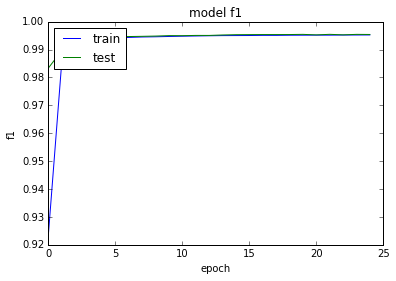

In [52]:
import matplotlib.pyplot as plt
# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

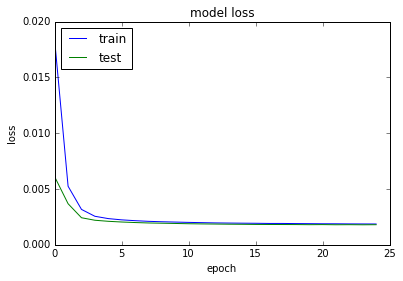

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model 2. Cat boost

In [ ]:
import numpy as np
from catboost import CatBoostClassifier, CatboostIpythonWidget
# specify the training parameters 
model = CatBoostClassifier(iterations=50, depth=10, learning_rate=1,
                           loss_function='MultiClass', calc_feature_importance=True)
#train the model
model.fit(X_train_matrix_raw, y_train_vector_raw, cat_features=cat_features)
#model.fit(X_train_matrix, y_train_vector, eval_set=(X_test_matrix_raw, y_test_vector_raw))
#make the prediction using the resulting model

In [7]:
preds_class = model.predict(X_test_matrix_raw)

In [26]:
import matplotlib
%matplotlib
import seaborn as sns
target_names = ['normal','prop','dos','u2r','r2l']
print(classification_report(y_test_vector_raw, preds_class, target_names=target_names, digits=4))
labels = X_train_raw.columns
stats = model.get_feature_importance(X=X_test_matrix_raw,
                       y=y_test_vector_raw,
                       cat_features=cat_features,
                       thread_count=2,
                       fstr_type='FeatureImportance')
sns.barplot(x=np.sort([i for i in stats]),y=[i for i in labels])

Using matplotlib backend: TkAgg
             precision    recall  f1-score   support

     normal     0.9996    0.9998    0.9997    625708
       prop     0.9944    0.9885    0.9915     10619
        dos     0.9998    0.9997    0.9997    190582
        u2r     0.8947    0.4048    0.5574        42
        r2l     0.9368    0.9057    0.9210       785

avg / total     0.9995    0.9995    0.9995    827736



In [39]:
import scorer
print(scorer.classification_report(y_test_vector_raw, preds_class, target_names=target_names, digits=4))

             precision    recall  f1-score   support

     normal     0.9996    0.9998    0.9997    625708
       prop     0.9944    0.9885    0.9915     10619
        dos     0.9998    0.9997    0.9997    190582
        u2r     0.8947    0.4048    0.5574        42
        r2l     0.9368    0.9057    0.9210       785

avg / total     0.9995    0.9995    0.8938    827736

